In [3]:
# All imports for MBNN (Multi-Branch Neural Network) for PFAS efficiency prediction
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, Dataset
from torch_geometric.data import Data, Batch
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.loader import DataLoader as PyGDataLoader
import pandas as pd
import numpy as np
from rdkit import Chem
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import shap

In [4]:
# Load data
exp_data = pd.read_csv("data.csv")
chem_data = pd.read_excel("enhanced_chem_data.xlsx")
exp_features_data = exp_data.drop(columns=['Efficiency_transformed'])

In [5]:
# Random seed
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.cuda.manual_seed_all(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
a1 = np.random.rand(3)
a2 = np.random.rand(3)
b1 = torch.rand(3)
b2 = torch.rand(3)

Experimental data shape: (78, 11)
Chemical data shape: (4, 12)
Epoch [20/500]
Train Loss: 0.3965, Val Loss: 0.2796
Branch Importance: Exp=0.367, Chem=0.194, Graph=0.439
Epoch [40/500]
Train Loss: 0.1781, Val Loss: 0.0774
Branch Importance: Exp=0.287, Chem=0.168, Graph=0.545
Epoch [60/500]
Train Loss: 0.1591, Val Loss: 0.0366
Branch Importance: Exp=0.308, Chem=0.193, Graph=0.499
Epoch [80/500]
Train Loss: 0.1710, Val Loss: 0.0227
Branch Importance: Exp=0.269, Chem=0.154, Graph=0.577
Epoch [100/500]
Train Loss: 0.1567, Val Loss: 0.0241
Branch Importance: Exp=0.324, Chem=0.133, Graph=0.543
Epoch [120/500]
Train Loss: 0.1614, Val Loss: 0.0260
Branch Importance: Exp=0.310, Chem=0.151, Graph=0.539
Epoch [140/500]
Train Loss: 0.1181, Val Loss: 0.0167
Branch Importance: Exp=0.259, Chem=0.135, Graph=0.606
Epoch [160/500]
Train Loss: 0.1002, Val Loss: 0.0138
Branch Importance: Exp=0.272, Chem=0.154, Graph=0.573
Epoch [180/500]
Train Loss: 0.1216, Val Loss: 0.0374
Branch Importance: Exp=0.280, Ch

/var/folders/q6/fx9pdmw93d78kwscc37jqndw0000gn/T/ipykernel_54092/1143160471.py:372: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


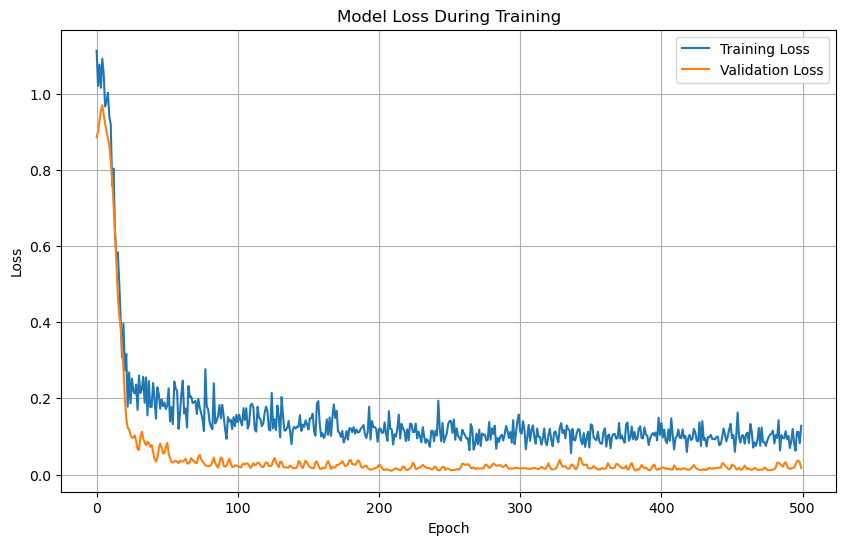


Drawing prediction scatter plot...


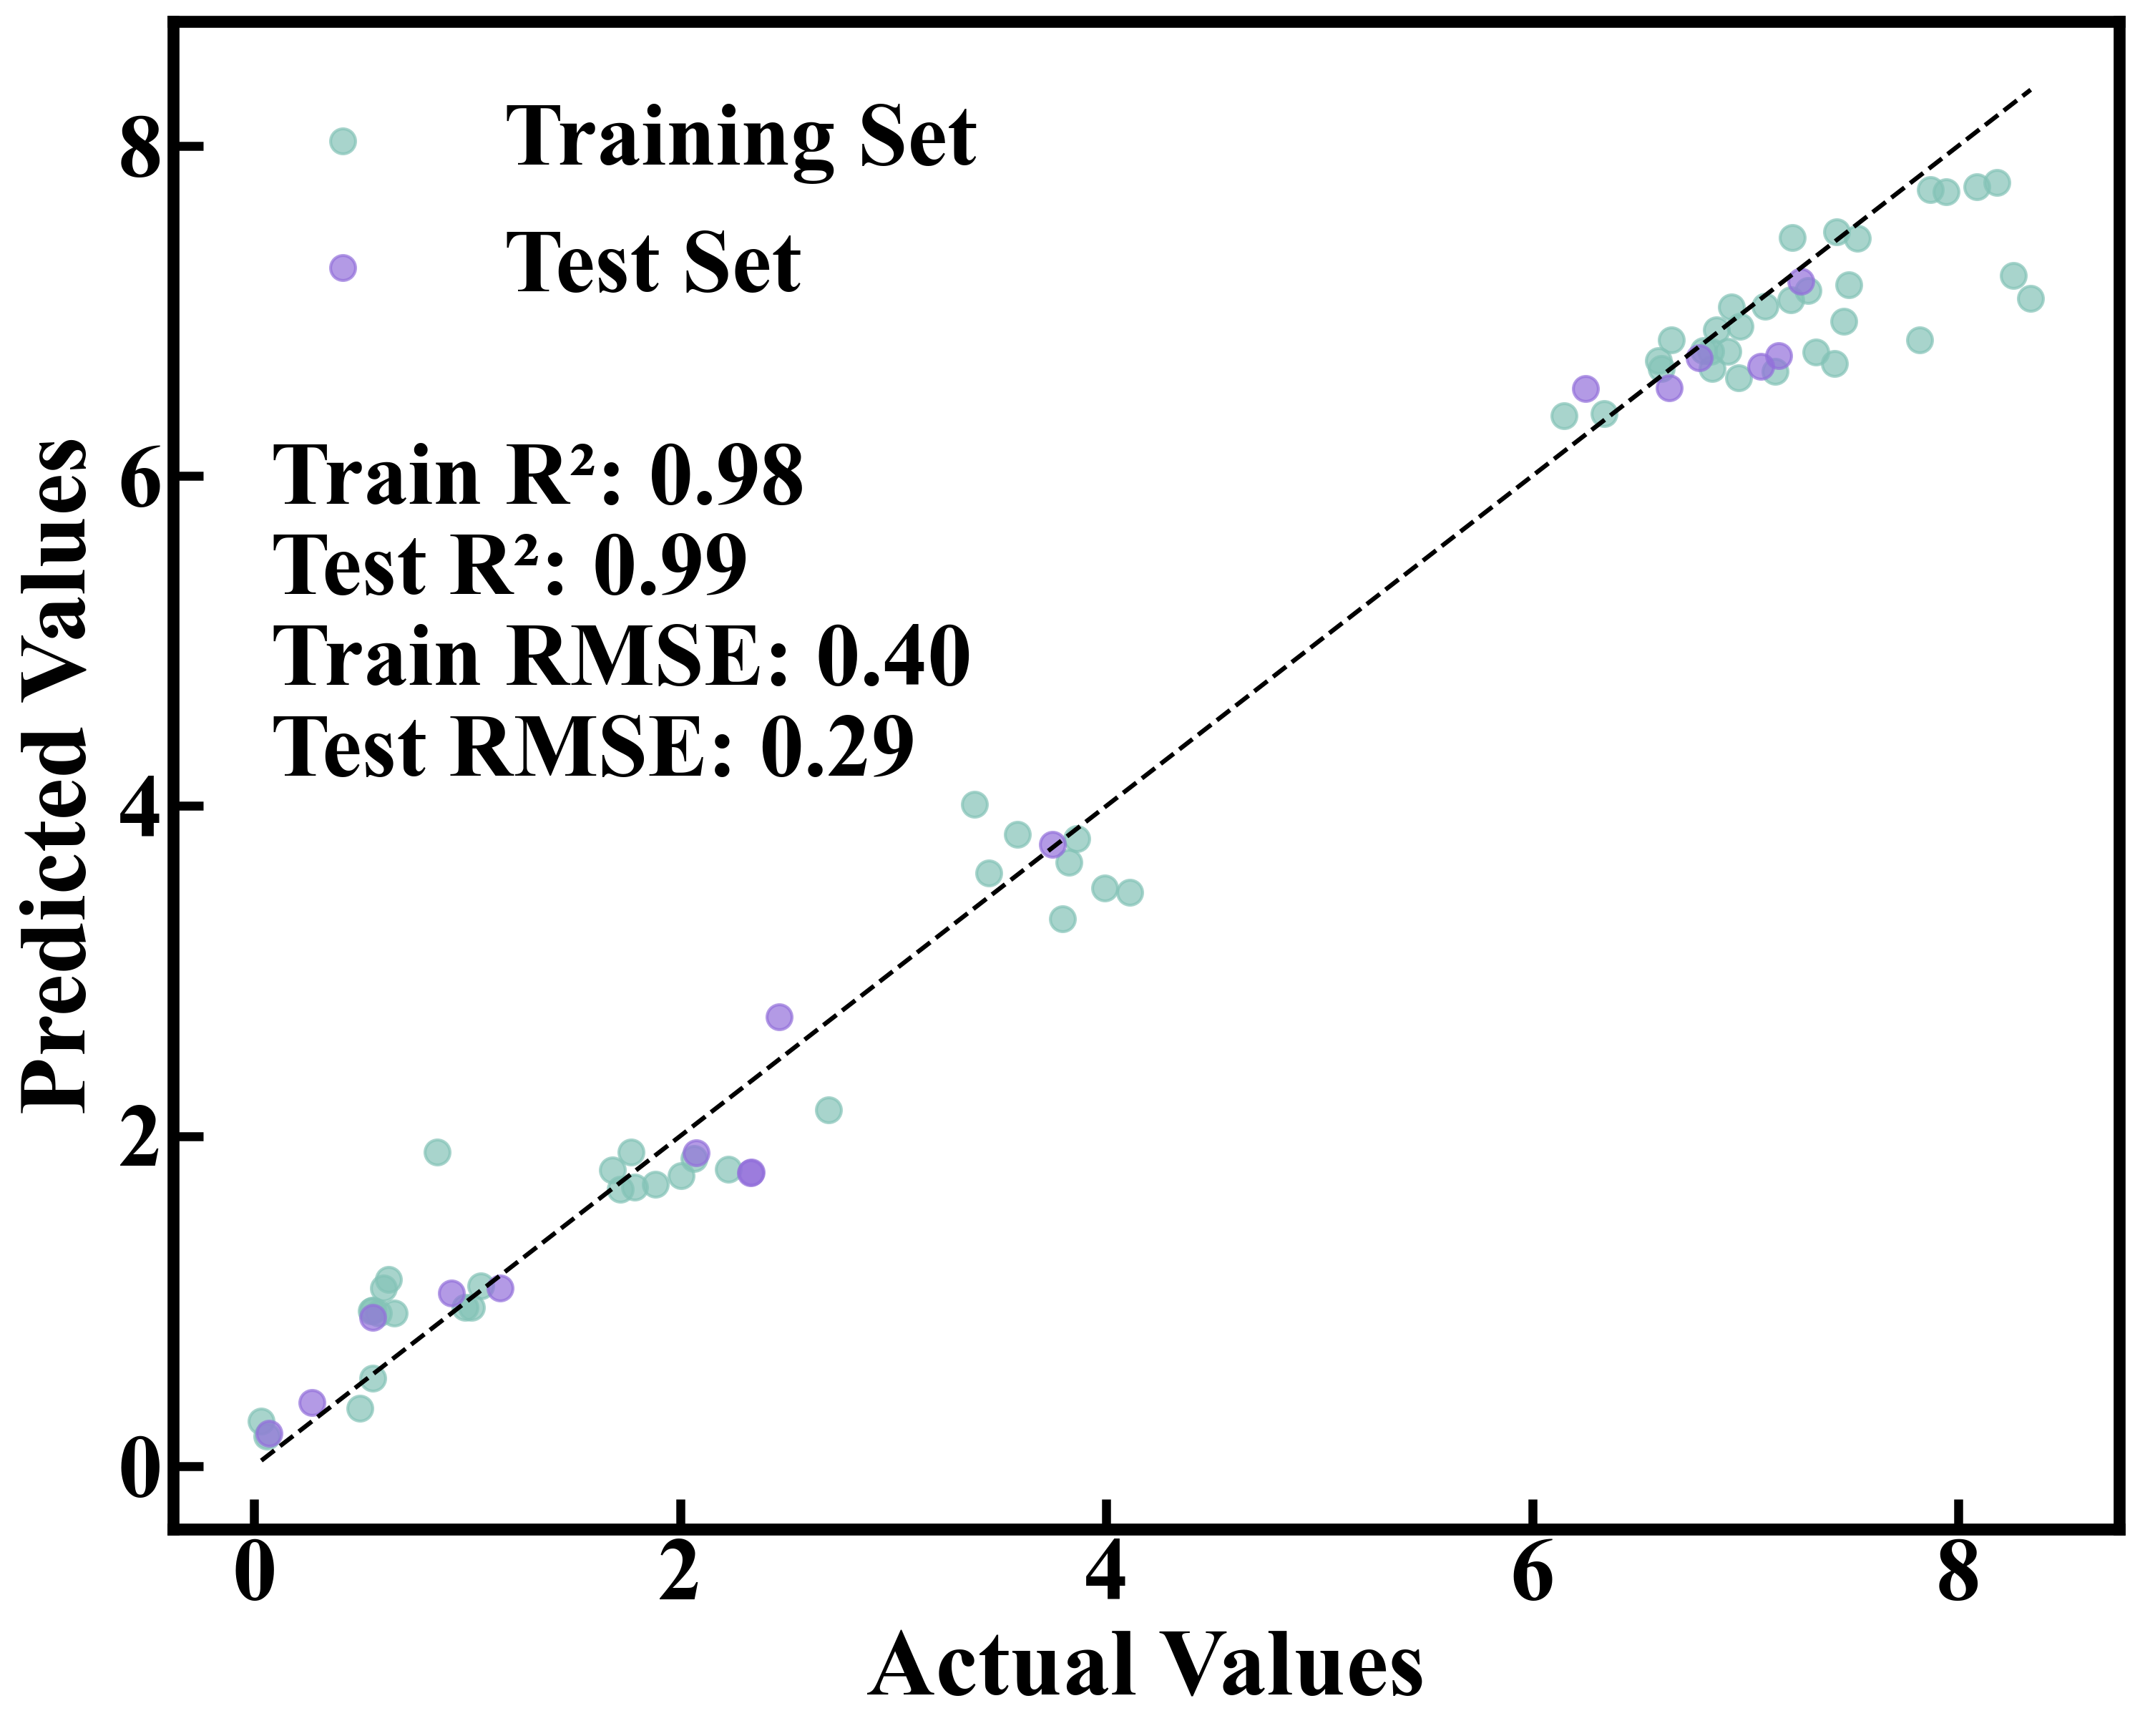


Detailed performance metrics:
Training R²: 0.9804
Training RMSE: 0.4047
Test R²: 0.9887
Test RMSE: 0.2873


In [6]:
# SMILES to graph conversion
def smiles_to_graph(smiles):
    mol = Chem.MolFromSmiles(smiles)
    
    # Use only atomic numbers as features
    atomic_numbers = []
    for atom in mol.GetAtoms():
        atomic_numbers.append(atom.GetAtomicNum())
    x = torch.tensor(atomic_numbers, dtype=torch.float).view(-1, 1)
    
    edges_src = []
    edges_dst = []
    for bond in mol.GetBonds():
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()
        edges_src.extend([i, j])
        edges_dst.extend([j, i])
    
    if len(edges_src) == 0:
        num_nodes = len(atomic_numbers)
        edges_src = list(range(num_nodes))
        edges_dst = list(range(num_nodes))
    
    edge_index = torch.tensor([edges_src, edges_dst], dtype=torch.long)
    
    return Data(x=x, edge_index=edge_index)

class MoleculeDataset(Dataset):
    def __init__(self, X_exp, X_chem, graphs, y):
        self.X_exp = X_exp
        self.X_chem = X_chem
        self.graphs = graphs
        self.y = y
    
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        graph = self.graphs[idx]
    # Add an extra dimension so that each attribute is a 2D tensor.
        graph.exp_features = self.X_exp[idx].unsqueeze(0)   # from (9,) to (1, 9)
        graph.chem_features = self.X_chem[idx].unsqueeze(0)  # from (19,) to (1, 19)
        graph.y = self.y[idx].unsqueeze(0)                   # from (1,) to (1, 1) ideally
        return graph


class ThreeStreamNN(nn.Module):
    def __init__(self, exp_input_size, chem_input_size):
        super(ThreeStreamNN, self).__init__()
        
        # Experimental data branch kept simple
        self.exp_branch = nn.Sequential(
            nn.Linear(exp_input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            #nn.BatchNorm1d(128),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            #nn.BatchNorm1d(64),
            nn.Linear(32, 16),
        )
        
        # Enhanced chemical features branch
        """self.chem_attention = nn.Sequential(
            nn.Linear(chem_input_size, 64),
            nn.ReLU(),
            nn.Linear(64, chem_input_size),
            nn.Sigmoid()
        )"""
        
        self.chem_branch = nn.Sequential(
            nn.Linear(chem_input_size, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            #nn.BatchNorm1d(64),  # Add batch normalization
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            #nn.BatchNorm1d(32),
            nn.Linear(32, 16),
        )
        
        # Simplified graph structure branch
        self.graph_embedding = nn.Linear(1, 64)
        self.graph_conv1 = GCNConv(64, 32)
        self.graph_conv2 = GCNConv(32, 16)
        
        # Increase initial weights for chemical features and use log space
        #self.stream_weights = nn.Parameter(torch.FloatTensor([1, 1, 1]))
        self.fusion_layer = nn.Sequential(
            nn.Linear(16 * 3, 32),  # 16 is the output dimension of three branches, 3 is the number of branches
            #nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16)
        )
        
        # Adjust final layer
        self.final_layer = nn.Sequential(
            nn.Linear(16, 8),
            nn.ReLU(),
            #nn.BatchNorm1d(8),
            nn.Dropout(0.2),
            nn.Linear(8, 1)
        )
        
    def forward(self, batch):
        # Experimental data processing
        exp_out = self.exp_branch(batch.exp_features)
        
        # Chemical feature processing - add attention mechanism
        #chem_attention = self.chem_attention(batch.chem_features)
        chem_features = batch.chem_features
        chem_out = self.chem_branch(chem_features)
        
        # Graph data processing
        x = batch.x.float()
        x = self.graph_embedding(x)
        edge_index = batch.edge_index
        batch_idx = batch.batch
        
        x = F.relu(self.graph_conv1(x, edge_index))
        graph_out = F.relu(self.graph_conv2(x, edge_index))
        graph_out = global_mean_pool(graph_out, batch_idx)
        
        # Use softplus to ensure weights are positive and chemical feature weights remain large
        #weights = F.softplus(self.stream_weights)
        #weights = weights / weights.sum()  # Normalization
        
        # Weighted fusion of three branch outputs
        """combined = (weights[0] * exp_out + 
                   weights[1] * chem_out + 
                   weights[2] * graph_out)"""
        combined = torch.cat([exp_out, chem_out, graph_out], dim=1)
        fused = self.fusion_layer(combined)
        
        # Final prediction
        final_out = self.final_layer(fused)
        return final_out

    """def get_stream_weights(self):
        return F.softmax(self.stream_weights, dim=0)"""
    def get_branch_importance(self, batch):
        with torch.no_grad():
            # Get outputs from each branch
            exp_out = self.exp_branch(batch.exp_features)
            
            #chem_attention = self.chem_attention(batch.chem_features)
            chem_features = batch.chem_features * 1
            chem_out = self.chem_branch(chem_features)
            
            x = batch.x.float()
            x = self.graph_embedding(x)
            edge_index = batch.edge_index
            batch_idx = batch.batch

            x = F.relu(self.graph_conv1(x, edge_index))
            graph_out = F.relu(self.graph_conv2(x, edge_index))
            graph_out = global_mean_pool(graph_out, batch_idx)
            
            # Calculate L2 norm of each branch output
            exp_norm = torch.norm(exp_out, p=2, dim=1)
            chem_norm = torch.norm(chem_out, p=2, dim=1)
            graph_norm = torch.norm(graph_out, p=2, dim=1)
            
            # Calculate relative importance
            total_norm = exp_norm + chem_norm + graph_norm
            exp_importance = (exp_norm / total_norm).mean()
            chem_importance = (chem_norm / total_norm).mean()
            graph_importance = (graph_norm / total_norm).mean()
            
            return {
                'experimental': exp_importance.item(),
                'chemical': chem_importance.item(),
                'graph': graph_importance.item()
            }

def prepare_data(exp_data, chem_data):
    # First save PFAS type information, but not as training features
    pfas_columns = ['PFOA', 'PFOS', 'PFHxS', 'PFBS']
    pfas_info = exp_data[pfas_columns]
    
    # Get target variable
    y = exp_data['Efficiency_transformed'].values
    
    # Extract experimental features, excluding unnecessary columns
    exp_features = exp_data.drop(columns=[
        'PFOA', 'PFOS', 'PFHxS', 'PFBS',
        'Efficiency', 
        'Weight Loss', 'Energy Comsumption', 
        'Efficiency_transformed', 
    ])

    chemical_features = []
    molecular_graphs = []
    
    # Use saved PFAS information to determine type
    for idx, row in pfas_info.iterrows():
        pfas_type = None
        for pfas in pfas_columns:
            if row[pfas] == 1:
                pfas_type = pfas
                break
        
        # Get corresponding chemical features
        chem_row = chem_data[chem_data['Type'] == pfas_type].iloc[0]
        smiles = chem_row['SMILES']
        
        num_features = chem_row.drop(['Type', 'SMILES']).values.astype(float)
        chemical_features.append(num_features)
        
        graph = smiles_to_graph(smiles)
        molecular_graphs.append(graph)
    
    # Standardization
    exp_scaler = StandardScaler()
    chem_scaler = StandardScaler()
    y_scaler = StandardScaler()
    
    X_exp = torch.FloatTensor(exp_scaler.fit_transform(exp_features))
    X_chem = torch.FloatTensor(chem_scaler.fit_transform(np.vstack(chemical_features)))
    y = torch.FloatTensor(y_scaler.fit_transform(y.reshape(-1, 1)).flatten())
    
    return X_exp, X_chem, molecular_graphs, y, y_scaler

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    best_val_loss = float('inf')
    patience = 300
    patience_counter = 0
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            outputs = model(batch)
            loss = criterion(outputs, batch.y.view(-1, 1))
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                batch = batch.to(device)
                outputs = model(batch)
                loss = criterion(outputs, batch.y.view(-1, 1))
                val_loss += loss.item()
        
        avg_val_loss = val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        
        if (epoch + 1) % 20 == 0:
            #current_weights = model.get_stream_weights()
            #print(f'Epoch [{epoch+1}/{num_epochs}]')
            #print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            #print(f'Stream Weights: Exp={current_weights[0]:.3f}, Chem={current_weights[1]:.3f}, Graph={current_weights[2]:.3f}')
            importance = model.get_branch_importance(next(iter(train_loader)).to(device))
            print(f'Epoch [{epoch+1}/{num_epochs}]')
            print(f'Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')
            print(f'Branch Importance: Exp={importance["experimental"]:.3f}, '
                  f'Chem={importance["chemical"]:.3f}, '
                  f'Graph={importance["graph"]:.3f}')
        
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_losses': train_losses,
                'val_losses': val_losses,
                'exp_input_size': model.exp_branch[0].in_features,  # 保存输入维度
                'chem_input_size': model.chem_branch[0].in_features
            }, 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
    
    return train_losses, val_losses

def evaluate_model(model, loader, y_scaler, device):
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            outputs = model(batch)
            predictions = y_scaler.inverse_transform(outputs.cpu().numpy())
            targets = y_scaler.inverse_transform(batch.y.cpu().numpy().reshape(-1, 1))
            
            all_predictions.extend(predictions.flatten())
            all_targets.extend(targets.flatten())
    
    y_pred = np.array(all_predictions)
    y_true = np.array(all_targets)
    
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    
    return mse, rmse, r2, mae, y_pred, y_true

def main():
    # Load data
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    exp_data = pd.read_csv("data.csv")
    chem_data = pd.read_excel("enhanced_chem_data.xlsx")
    
    print("Experimental data shape:", exp_data.shape)
    print("Chemical data shape:", chem_data.shape)
    
    # Prepare data
    X_exp, X_chem, graphs, y, y_scaler = prepare_data(exp_data, chem_data)
    
    # Create dataset
    dataset = MoleculeDataset(X_exp, X_chem, graphs, y)
    
    # Split data
    dataset_size = len(dataset)
    train_size = int(0.8 * dataset_size)
    val_size = dataset_size - train_size
    train_dataset, val_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size], 
        generator=torch.Generator().manual_seed(42)
    )
    
    # Create data loaders
    train_loader = PyGDataLoader(train_dataset, batch_size=16, shuffle=True)
    val_loader = PyGDataLoader(val_dataset, batch_size=16, shuffle=False)
    
    # Initialize model
    model = ThreeStreamNN(
        exp_input_size=X_exp.shape[1],
        chem_input_size=X_chem.shape[1]
    ).to(device)

    
    # Learning rate 0.001, weight_decay 1e-3, T_0 50, T_mult 2, eta_min 1e-6
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-3)
    
    scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(
        optimizer,
        T_0=50,  
        T_mult=2,  
        eta_min=1e-6  
    )

    # Train model
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, criterion, optimizer, 
        num_epochs=500, device=device
    )
    
    # Load best model and evaluate
    checkpoint = torch.load('best_model.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
    mse, rmse, r2, mae, y_pred, y_true = evaluate_model(model, val_loader, y_scaler, device)
    
    # Print final results
    print("\nFinal Model Evaluation Results:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2 Score: {r2:.4f}")
    print(f"MAE: {mae:.4f}")
    
    # Plot training curves
    plt.figure(figsize=(10, 6))
    plt.plot(train_losses, label='Training Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Add scatter plot section
    print("\nDrawing prediction scatter plot...")
    
    # Set high-resolution image parameters
    plt.rcParams['figure.dpi'] = 300
    plt.rcParams['savefig.dpi'] = 300
    plt.rcParams['font.size'] = 20
    plt.rcParams['font.family'] = 'Times New Roman'
    # Collect training set prediction results
    model.eval()
    train_predictions = []
    train_targets = []
    with torch.no_grad():
        for batch in train_loader:
            batch = batch.to(device)
            outputs = model(batch)
            predictions = y_scaler.inverse_transform(outputs.cpu().numpy())
            targets = y_scaler.inverse_transform(batch.y.cpu().numpy().reshape(-1, 1))
            
            train_predictions.extend(predictions.flatten())
            train_targets.extend(targets.flatten())
    
    # Collect test set prediction results
    val_predictions = []
    val_targets = []
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            outputs = model(batch)
            predictions = y_scaler.inverse_transform(outputs.cpu().numpy())
            targets = y_scaler.inverse_transform(batch.y.cpu().numpy().reshape(-1, 1))
            
            val_predictions.extend(predictions.flatten())
            val_targets.extend(targets.flatten())
    
    # Convert to numpy arrays
    train_predictions = np.array(train_predictions)
    train_targets = np.array(train_targets)
    val_predictions = np.array(val_predictions)
    val_targets = np.array(val_targets)
    
    # Calculate R² and RMSE for training and test sets
    train_r2 = r2_score(train_targets, train_predictions)
    train_rmse = np.sqrt(mean_squared_error(train_targets, train_predictions))
    val_r2 = r2_score(val_targets, val_predictions)
    val_rmse = np.sqrt(mean_squared_error(val_targets, val_predictions))
    
    # Draw scatter plot
    fig = plt.figure(figsize=(14, 12), dpi=300)
    
    # Find maximum and minimum values for setting axis range
    min_val = min(np.min(train_targets), np.min(val_targets), 
                 np.min(train_predictions), np.min(val_predictions))
    max_val = max(np.max(train_targets), np.max(val_targets), 
                 np.max(train_predictions), np.max(val_predictions))
    
    # Draw training set scatter plot
    plt.scatter(train_targets, train_predictions, 
                color='#84C3B7', marker='o', alpha=0.7, s=70, 
                label=f'Training Set')
    
    # Draw test set scatter plot
    plt.scatter(val_targets, val_predictions, 
                color='#9370DB', marker='o', alpha=0.7, s=70, 
                label=f'Test Set')
    
    # Draw diagonal line (y=x)
    plt.plot([min_val, max_val], [min_val, max_val], 
             color='black', linestyle='--', linewidth=1.5)
    
    # Set title and labels
    #plt.title('Predicted vs Actual Values', fontsize=18, fontweight='bold')
    plt.xlabel('Actual Values', fontsize=32, fontweight='bold', fontname='Times New Roman')
    plt.ylabel('Predicted Values', fontsize=32, fontweight='bold', fontname='Times New Roman')
    
    plt.text(min_val + (max_val-min_val)*0.005, max_val - (max_val-min_val)*0.5, 
             f'Train R²: {train_r2:.2f}\nTest R²: {val_r2:.2f}\nTrain RMSE: {train_rmse:.2f}\nTest RMSE: {val_rmse:.2f}', 
             fontsize=30, fontweight='bold', fontname='Times New Roman')
    
    # Adjust tick font
    plt.xticks(fontsize=25, fontweight='bold')
    plt.yticks(fontsize=25, fontweight='bold')
    
    ax = plt.gca()
    for spine in ax.spines.values():
        spine.set_linewidth(2) 
    # Add legend
    ax.tick_params(axis='both', which='major', labelsize=30, length = 10, width = 3, direction = 'in')
    for spine in ax.spines.values():
        spine.set_linewidth(4)

    for label in ax.get_xticklabels():
        label.set_fontweight('bold')
    
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

    legend_font = {'weight': 'bold', 'size': 30}
    legend = ax.legend(loc="upper left", frameon=False, prop=legend_font)
    
    # Adjust layout and save
    plt.tight_layout()
    fig.set_size_inches(10, 8)   
    plt.savefig('predictions_vs_actual.png', bbox_inches='tight')
    plt.show()
    
    # Print detailed metrics
    print("\nDetailed performance metrics:")
    print(f"Training R²: {train_r2:.4f}")
    print(f"Training RMSE: {train_rmse:.4f}")
    print(f"Test R²: {val_r2:.4f}")
    print(f"Test RMSE: {val_rmse:.4f}")

"""if __name__ == "__main__":
    torch.manual_seed(42)
    np.random.seed(42)
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    try:
        main()
    except Exception as e:
        print(f"Error during execution: {str(e)}")
    finally:
        plt.close('all')
        print("Program completed")"""
main()

Starting overfitting analysis...

Overfitting Analysis:
Final Training Loss: 0.1186
Final Validation Loss: 0.0099
Loss Ratio (Val/Train): 0.0839
Validation Loss Stability (std): 0.0072

Overfitting Severity: No significant

Training Phase Analysis:
Early Phase - Train: 0.3760, Val: 0.2555
Mid Phase   - Train: 0.1492, Val: 0.0272
Late Phase  - Train: 0.1236, Val: 0.0224


/var/folders/q6/fx9pdmw93d78kwscc37jqndw0000gn/T/ipykernel_54092/3683224546.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')


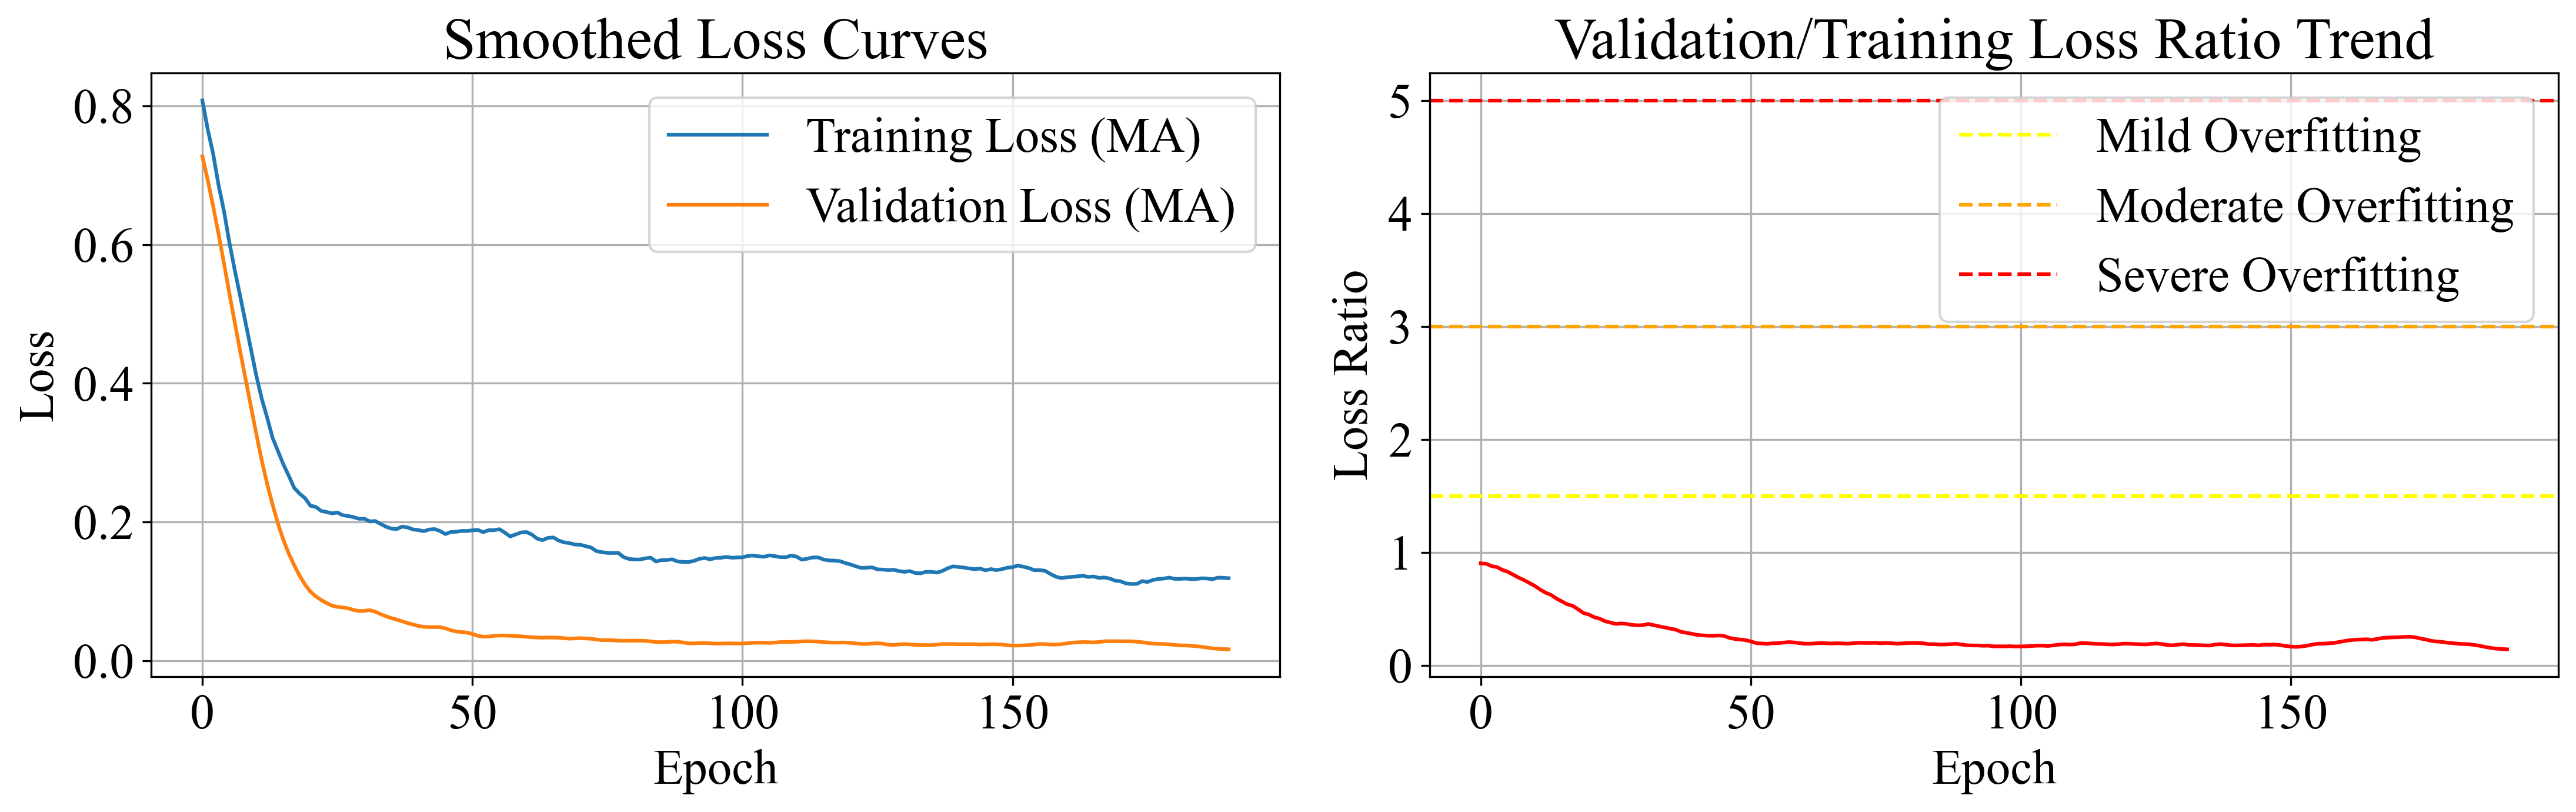


Recommendations based on analysis:
Model shows good balance between training and validation performance

Analysis completed!


In [7]:
def analyze_overfitting():
    # Load training history
    checkpoint = torch.load('best_model.pth')
    train_losses = checkpoint['train_losses']
    val_losses = checkpoint['val_losses']
    
    # Calculate key metrics
    final_train_loss = train_losses[-1]
    final_val_loss = val_losses[-1]
    loss_ratio = final_val_loss / final_train_loss
    
    # Calculate average losses for different training phases
    early_phase = slice(0, len(train_losses)//3)
    mid_phase = slice(len(train_losses)//3, 2*len(train_losses)//3)
    late_phase = slice(2*len(train_losses)//3, None)
    
    train_loss_trend = [
        np.mean(train_losses[early_phase]),
        np.mean(train_losses[mid_phase]), 
        np.mean(train_losses[late_phase])
    ]
    
    val_loss_trend = [
        np.mean(val_losses[early_phase]),
        np.mean(val_losses[mid_phase]),
        np.mean(val_losses[late_phase])
    ]
    
    # Calculate validation loss stability
    val_loss_std = np.std(val_losses[len(val_losses)//2:])
    
    print("\nOverfitting Analysis:")
    print(f"Final Training Loss: {final_train_loss:.4f}")
    print(f"Final Validation Loss: {final_val_loss:.4f}")
    print(f"Loss Ratio (Val/Train): {loss_ratio:.4f}")
    print(f"Validation Loss Stability (std): {val_loss_std:.4f}")
    
    # Determine overfitting severity
    if loss_ratio > 5:
        severity = "Severe"
    elif loss_ratio > 3:
        severity = "Moderate"
    elif loss_ratio > 1.5:
        severity = "Mild"
    else:
        severity = "No significant"
    
    print(f"\nOverfitting Severity: {severity}")
    
    # Training phase analysis
    print("\nTraining Phase Analysis:")
    print("Early Phase - Train: {:.4f}, Val: {:.4f}".format(
        train_loss_trend[0], val_loss_trend[0]))
    print("Mid Phase   - Train: {:.4f}, Val: {:.4f}".format(
        train_loss_trend[1], val_loss_trend[1]))
    print("Late Phase  - Train: {:.4f}, Val: {:.4f}".format(
        train_loss_trend[2], val_loss_trend[2]))
    
    # Plot detailed analysis
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Loss Curves with Moving Average
    plt.subplot(1, 2, 1)
    window = 20
    train_ma = np.convolve(train_losses, np.ones(window)/window, mode='valid')
    val_ma = np.convolve(val_losses, np.ones(window)/window, mode='valid')
    
    plt.plot(train_ma, label='Training Loss (MA)')
    plt.plot(val_ma, label='Validation Loss (MA)')
    plt.title('Smoothed Loss Curves')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    
    # Plot 2: Loss Ratio Trend
    plt.subplot(1, 2, 2)
    loss_ratios = np.array(val_losses) / (np.array(train_losses) + 1e-10)
    ratio_ma = np.convolve(loss_ratios, np.ones(window)/window, mode='valid')
    
    plt.plot(ratio_ma, color='red')
    plt.axhline(y=1.5, color='yellow', linestyle='--', label='Mild Overfitting')
    plt.axhline(y=3.0, color='orange', linestyle='--', label='Moderate Overfitting')
    plt.axhline(y=5.0, color='red', linestyle='--', label='Severe Overfitting')
    plt.title('Validation/Training Loss Ratio Trend')
    plt.xlabel('Epoch')
    plt.ylabel('Loss Ratio')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Provide recommendations
    print("\nRecommendations based on analysis:")
    if loss_ratio > 3:
        print("1. Increase regularization (L2 weight decay)")
        print("2. Increase dropout rate")
        print("3. Reduce model complexity")
        print("4. Implement early stopping")
    elif loss_ratio > 1.5:
        print("1. Consider mild regularization increase")
        print("2. Monitor training for longer")
        print("3. Implement learning rate scheduling")
    else:
        print("Model shows good balance between training and validation performance")
        if val_loss_std > 0.1:
            print("Consider learning rate adjustment to stabilize validation loss")

if __name__ == "__main__":
    try:
        print("Starting overfitting analysis...")
        analyze_overfitting()
        print("\nAnalysis completed!")
    except Exception as e:
        print(f"Error during analysis: {str(e)}")
    finally:
        plt.close('all')

In [8]:
def analyze_all_features_shap():
    try:
        # Load data and models
        exp_data = pd.read_csv("data.csv")
        chem_data = pd.read_excel("enhanced_chem_data.xlsx")
        X_exp, X_chem, graphs, y, y_scaler = prepare_data(exp_data, chem_data)
        
        # Get feature names
        exp_feature_names = exp_data.drop(columns=[
        'PFOA', 'PFOS', 'PFHxS', 'PFBS',
        'Efficiency', 
        'Weight Loss', 'Energy Comsumption', 
        'Efficiency_transformed', 
        ]).columns.tolist()

        chem_feature_names = chem_data.drop(['Type', 'SMILES'], axis=1).columns.tolist()
        all_feature_names = exp_feature_names + chem_feature_names
        
        # Combine features
        X_combined = torch.cat([X_exp, X_chem], dim=1).numpy()
        
        # Load model
        model = ThreeStreamNN(
            exp_input_size=X_exp.shape[1],
            chem_input_size=X_chem.shape[1]
        )
        checkpoint = torch.load('best_model.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        model.eval()
        
        # Define prediction function
        def f(X):
            with torch.no_grad():
                X_tensor = torch.FloatTensor(X)
                exp_part = X_tensor[:, :len(exp_feature_names)]
                chem_part = X_tensor[:, len(exp_feature_names):]
                
                # Get outputs from each branch
                exp_out = model.exp_branch(exp_part)
                chem_out = model.chem_branch(chem_part)
                
                # Create dummy graph output (same batch size and feature dimension as exp_out and chem_out)
                batch_size = exp_out.shape[0]
                graph_out = torch.zeros((batch_size, 16), device=exp_out.device)
                
                # Use fusion layer
                combined = torch.cat([exp_out, chem_out, graph_out], dim=1)
                fused = model.fusion_layer(combined)
                
                # Final prediction
                return model.final_layer(fused).numpy().reshape(-1)
        
        # Print dimension information for debugging
        print("\nModel architecture:")
        print(model)
        
        # Prepare SHAP analysis
        n_background = min(80, len(X_combined))
        background_indices = np.random.choice(len(X_combined), n_background, replace=False)
        background_data = X_combined[background_indices]
        
        # Test prediction function
        print("\nTesting prediction function...")
        test_output = f(background_data)
        print(f"Test output shape: {test_output.shape}")
        
        print("Creating SHAP explainer...")
        explainer = shap.KernelExplainer(f, background_data)
        
        # Select samples for analysis
        n_samples = 78
        sample_indices = np.random.choice(len(X_combined), n_samples, replace=False)
        sample_data = X_combined[sample_indices]
        
        print("Calculating SHAP values...")
        shap_values = explainer.shap_values(sample_data)
        
        # Ensure shap_values is one-dimensional
        if isinstance(shap_values, list):
            shap_values = np.array(shap_values[0])
        if len(shap_values.shape) > 2:
            shap_values = shap_values.mean(axis=2)
        
        # Calculate feature importance
        feature_importance = np.abs(shap_values).mean(axis=0)
        
        # Create feature importance DataFrame
        importance_data = {
            'Feature': all_feature_names,
            'Importance': feature_importance.tolist(),
            'Type': ['Experimental']*len(exp_feature_names) + ['Chemical']*len(chem_feature_names)
        }
        
        # Verify data dimensions
        print("\nData dimensions check:")
        for key, value in importance_data.items():
            print(f"{key}: length = {len(value)}")
        
        importance_df = pd.DataFrame(importance_data)
        importance_df = importance_df.sort_values('Importance', ascending=False)
        chemical_df = importance_df[importance_df['Type'] == 'Chemical']

        plt.rcParams['figure.dpi'] = 300  # 提高DPI
        plt.rcParams['savefig.dpi'] = 300
        plt.rcParams['font.size'] = 14  # 增大字体
        plt.rcParams['axes.linewidth'] = 1.5  # 加粗轴线
        plt.rcParams['axes.labelsize'] = 14
        plt.rcParams['axes.titlesize'] = 16

        top_8_df = chemical_df.head(8)[::-1]

        feature_rename = {
            "Sulfonic_count": r"SO$_3$",
            "Carboxylic_count": "COOH",
            "MolWt_per_atom": "AAW",
            "MaxPartialCharge": "MPAC",
            "C_F_bonds": "C-F Bonds",
            "MolWt": "MW",
            "NumHeteroatoms": "HC"
            }
       
        top_8_df['Feature'] = top_8_df['Feature'].replace(feature_rename)
        top_8_df['Importance'] = top_8_df['Importance'] * 100
        fig = plt.figure(figsize=(10, 8), dpi=600)
        plt.barh(top_8_df['Feature'], top_8_df['Importance'], color='royalblue')
        plt.xlabel("mean(|SHAP value|)", fontsize=28, fontweight='bold')
        ax = plt.gca()
        ax.tick_params(axis='y', labelsize=28)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
        ax.tick_params(axis='x', labelsize=28)
        for label in ax.get_xticklabels():
            label.set_fontweight('bold')
        ax.set_ylabel(ax.get_ylabel(), fontsize=28, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=28, length=10, width=3, direction='in')

        for spine in ax.spines.values():
            spine.set_linewidth(4)
            spine.set_color('black')
        ax.tick_params(width=2, colors = 'black')
        fig.set_size_inches(10, 8)  
        plt.tight_layout()
        plt.show()

        
        # SHAP scatter plot
        top8_chemical = importance_df[importance_df['Type'] == 'Chemical'].sort_values('Importance', ascending=False).head(8)
        chemical_features = top8_chemical['Feature'].tolist()
        chemical_indices = [i for i, f in enumerate(all_feature_names) if f in chemical_features]
        shap_values_chem = shap_values[:, chemical_indices] *100
        feature_names_chem = [all_feature_names[i] for i in chemical_indices]
        feature_names_chem = [feature_rename.get(f, f) for f in feature_names_chem]


        '''fig = plt.figure(figsize=(12, 6), dpi=300)
        ax = fig.add_subplot(111)
        shap.summary_plot(
            shap_values_chem,
            sample_data[:, chemical_indices], 
            feature_names=feature_names_chem,
            show=False
        )
        ax = plt.gca()
        ax.tick_params(axis='y', labelsize=20)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
        ax.tick_params(axis='x', labelsize=20)
        for label in ax.get_xticklabels():
            label.set_fontweight('bold')
        ax.set_ylabel(ax.get_ylabel(), fontsize=20, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=20)

        for spine in ax.spines.values():
            spine.set_linewidth(2)
            spine.set_color('black')
        ax.tick_params(width=2, colors = 'black')
        plt.xlabel("SHAP Value", fontsize=20, fontweight='bold')
        cbar = plt.gcf().axes[-1]
        cbar.tick_params(labelsize=20)
        cbar.set_ylabel('Feature Value', fontsize=20, fontweight='bold')
        fig.set_size_inches(12, 6)   
        plt.tight_layout()
        plt.show()'''
        
        feature_names_chem = [feature_rename.get(f, f) for f in chemical_features]
        chemical_indices = [all_feature_names.index(f) for f in chemical_features]
        shap_values_chem = shap_values[:, chemical_indices] * 100
        sample_data_chem = sample_data[:, chemical_indices]

        feature_names_chem = feature_names_chem[::-1]
        shap_values_chem = shap_values_chem[:, ::-1]
        sample_data_chem = sample_data_chem[:, ::-1]

        fig = plt.figure(figsize=(10, 8), dpi=600)
        
        cmap = plt.get_cmap('coolwarm')
        jitter_strength = 0.2

        for i, feature in enumerate(feature_names_chem):
            y = np.ones_like(shap_values_chem[:, i]) * i
            norm = (sample_data_chem[:, i] - np.min(sample_data_chem[:, i])) / (np.max(sample_data_chem[:, i]) - np.min(sample_data_chem[:, i]) + 1e-8)
            sc = plt.scatter(shap_values_chem[:, i], y + np.random.uniform(-jitter_strength, jitter_strength, size=len(y)),
                     c=norm, cmap=cmap, s=50, alpha=0.8, edgecolors='none')

        plt.yticks(range(len(feature_names_chem)), feature_names_chem, fontsize=20, fontweight='bold')
        plt.xlabel("SHAP Value", fontsize=28, fontweight='bold')
        plt.xlim(np.min(shap_values_chem)-1, np.max(shap_values_chem)+1)
        plt.axvline(x=0, color='gray', linestyle='-', linewidth=2, alpha=0.5)
        #color bar
        cbar = plt.colorbar(sc, orientation='vertical', pad=0.02)
        cbar.set_label('Feature Value', fontsize=28, fontweight='bold')
        cbar.ax.tick_params(labelsize=28)
        cbar.set_ticks([cbar.vmin, cbar.vmax])
        cbar.set_ticklabels(['Low', 'High'])

        ax = plt.gca()
        ax.tick_params(axis='y', labelsize=28)
        for label in ax.get_yticklabels():
            label.set_fontweight('bold')
        ax.tick_params(axis='x', labelsize=28)
        for label in ax.get_xticklabels():
            label.set_fontweight('bold')
        ax.set_ylabel(ax.get_ylabel(), fontsize=28, fontweight='bold')
        ax.tick_params(axis='both', which='major', labelsize=28,length=10, width=3, direction='in')
        for label in cbar.ax.get_yticklabels():
            label.set_fontweight('bold')
        for spine in ax.spines.values():
            spine.set_linewidth(4)
            spine.set_color('black')
        ax.tick_params(width=2, colors = 'black')
        fig.set_size_inches(10, 8)  
        plt.tight_layout()
        plt.show()

        # 不返回DataFrame，避免输出表格
        return None
        
    except Exception as e:
        print(f"Error in analyze_all_features_shap: {str(e)}")
        
        return None

/var/folders/q6/fx9pdmw93d78kwscc37jqndw0000gn/T/ipykernel_54092/3004327059.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')



Model architecture:
ThreeStreamNN(
  (exp_branch): Sequential(
    (0): Linear(in_features=3, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
  (chem_branch): Sequential(
    (0): Linear(in_features=10, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=64, out_features=32, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=32, out_features=16, bias=True)
  )
  (graph_embedding): Linear(in_features=1, out_features=64, bias=True)
  (graph_conv1): GCNConv(64, 32)
  (graph_conv2): GCNConv(32, 16)
  (fusion_layer): Sequential(
    (0): Linear(in_features=48, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_fe

100%|██████████| 78/78 [00:09<00:00,  8.24it/s]



Data dimensions check:
Feature: length = 13
Importance: length = 13
Type: length = 13


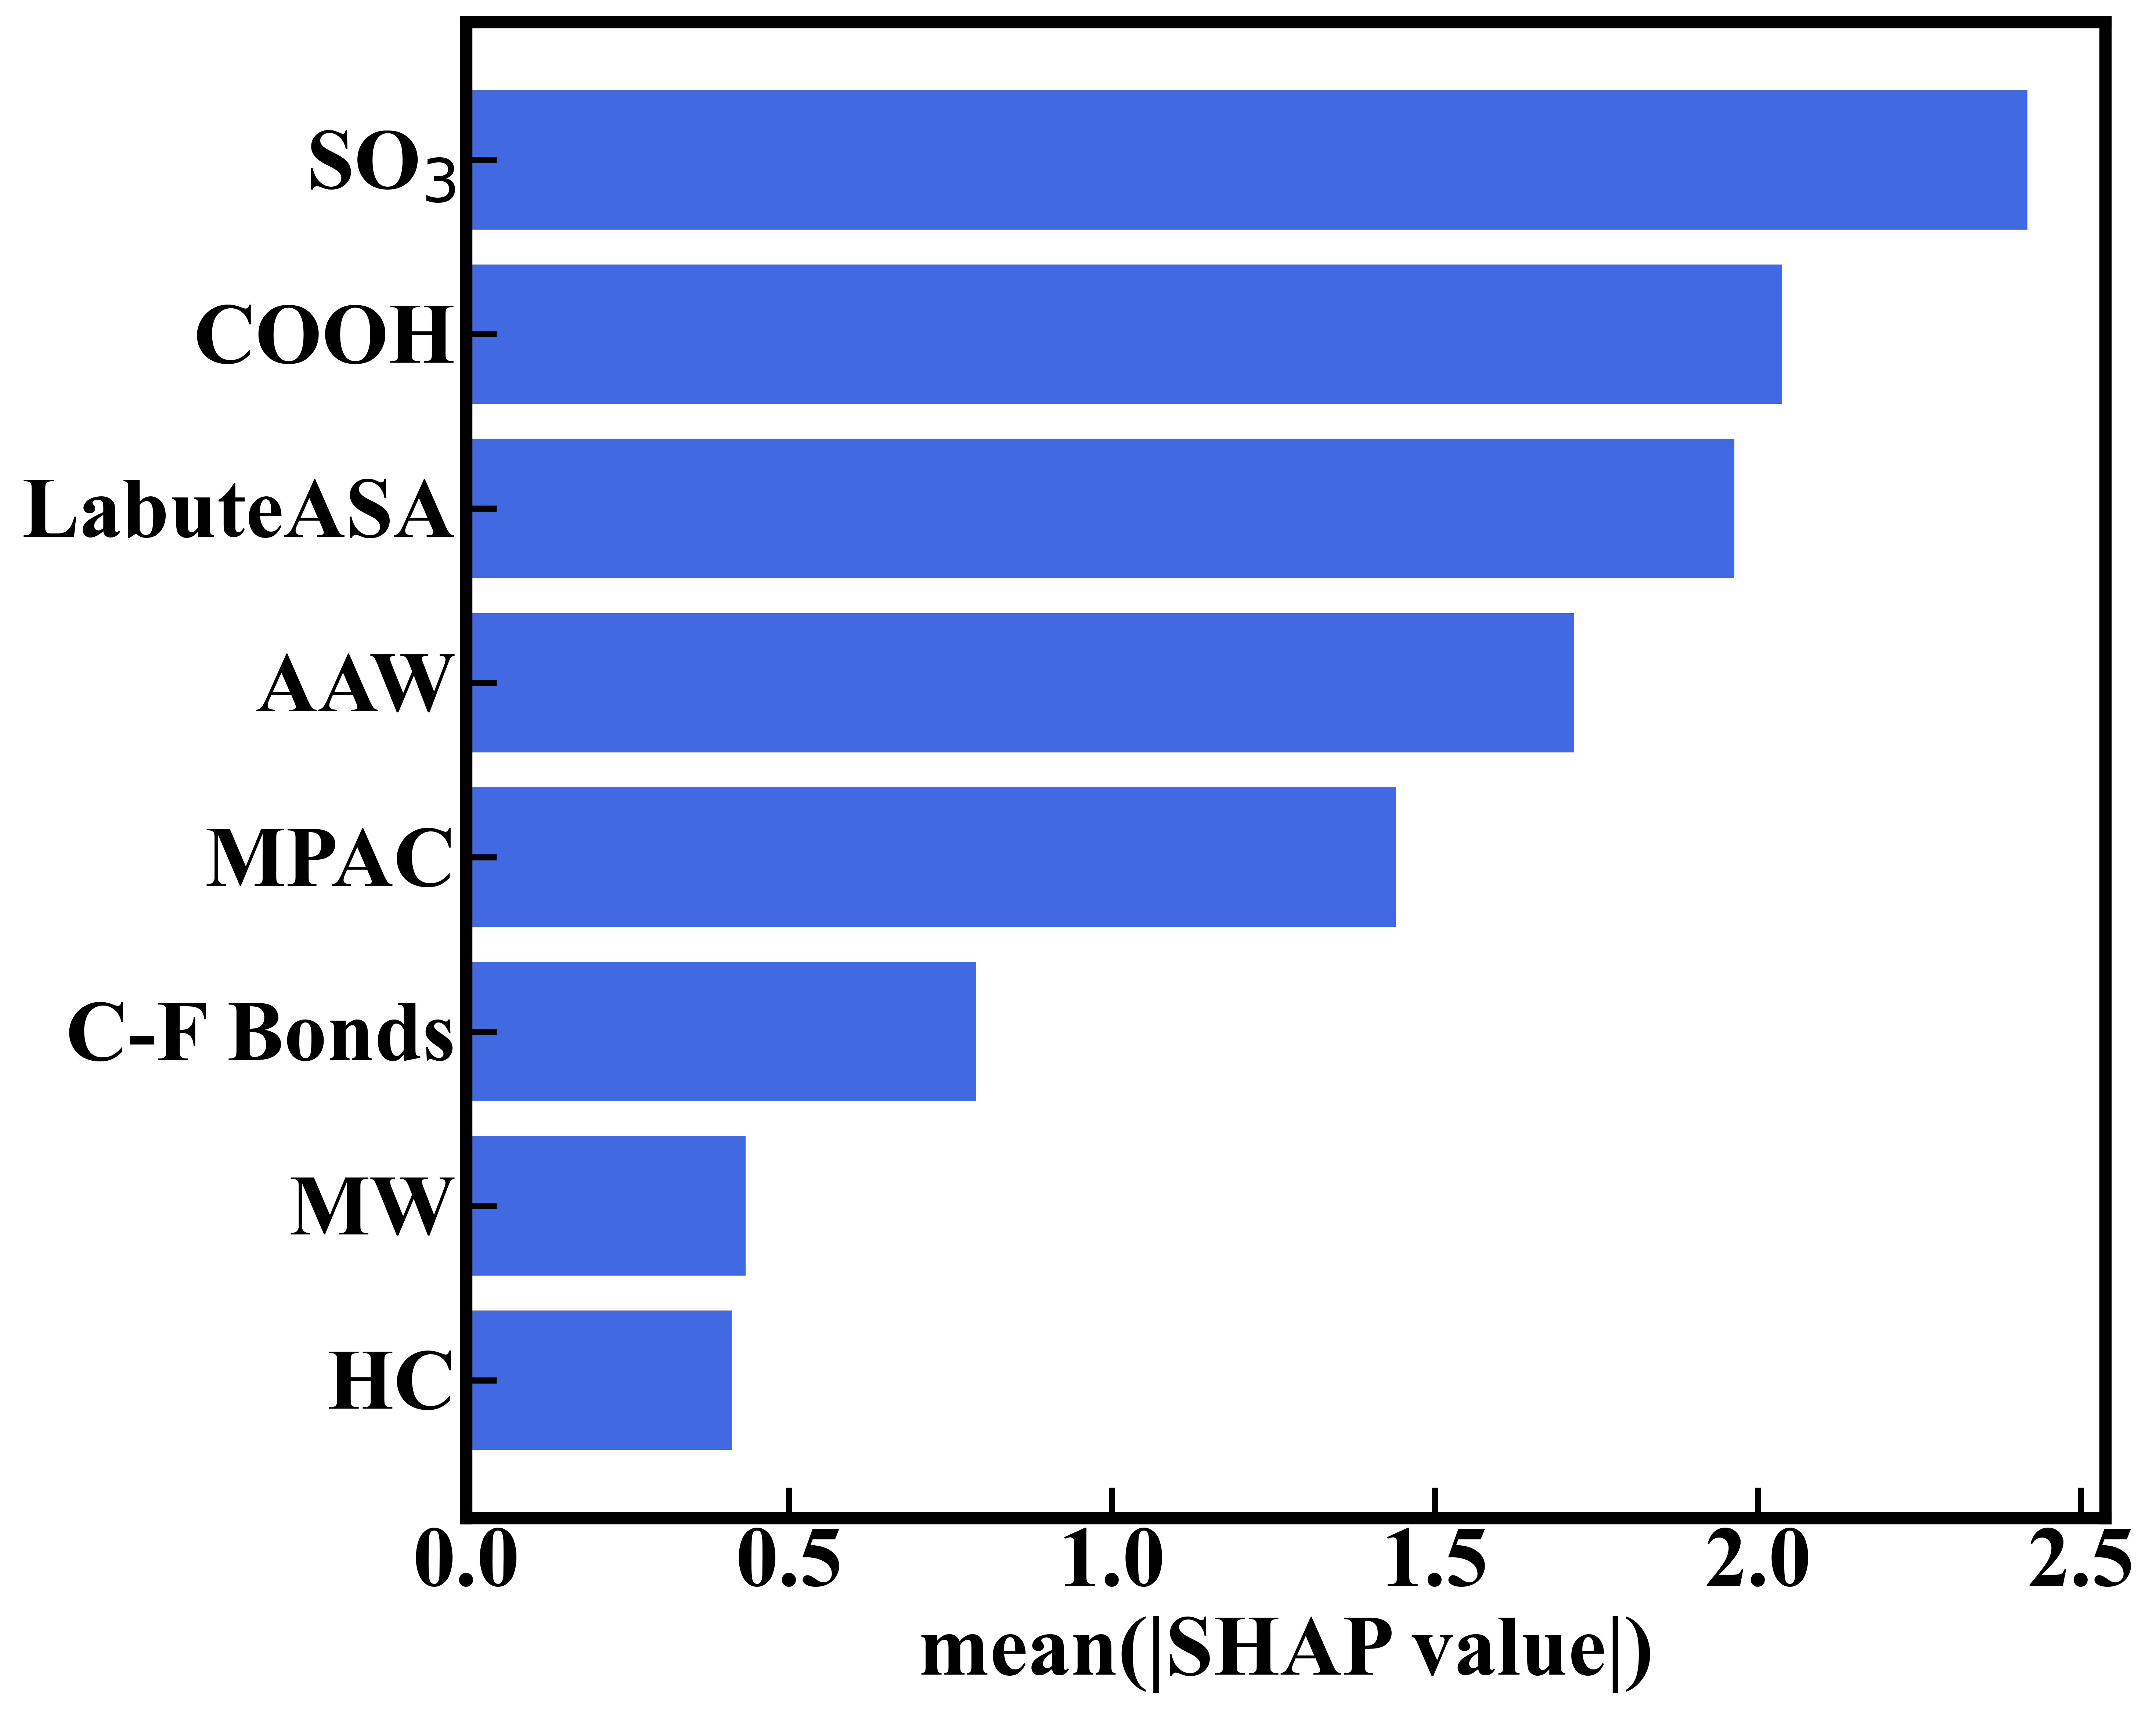

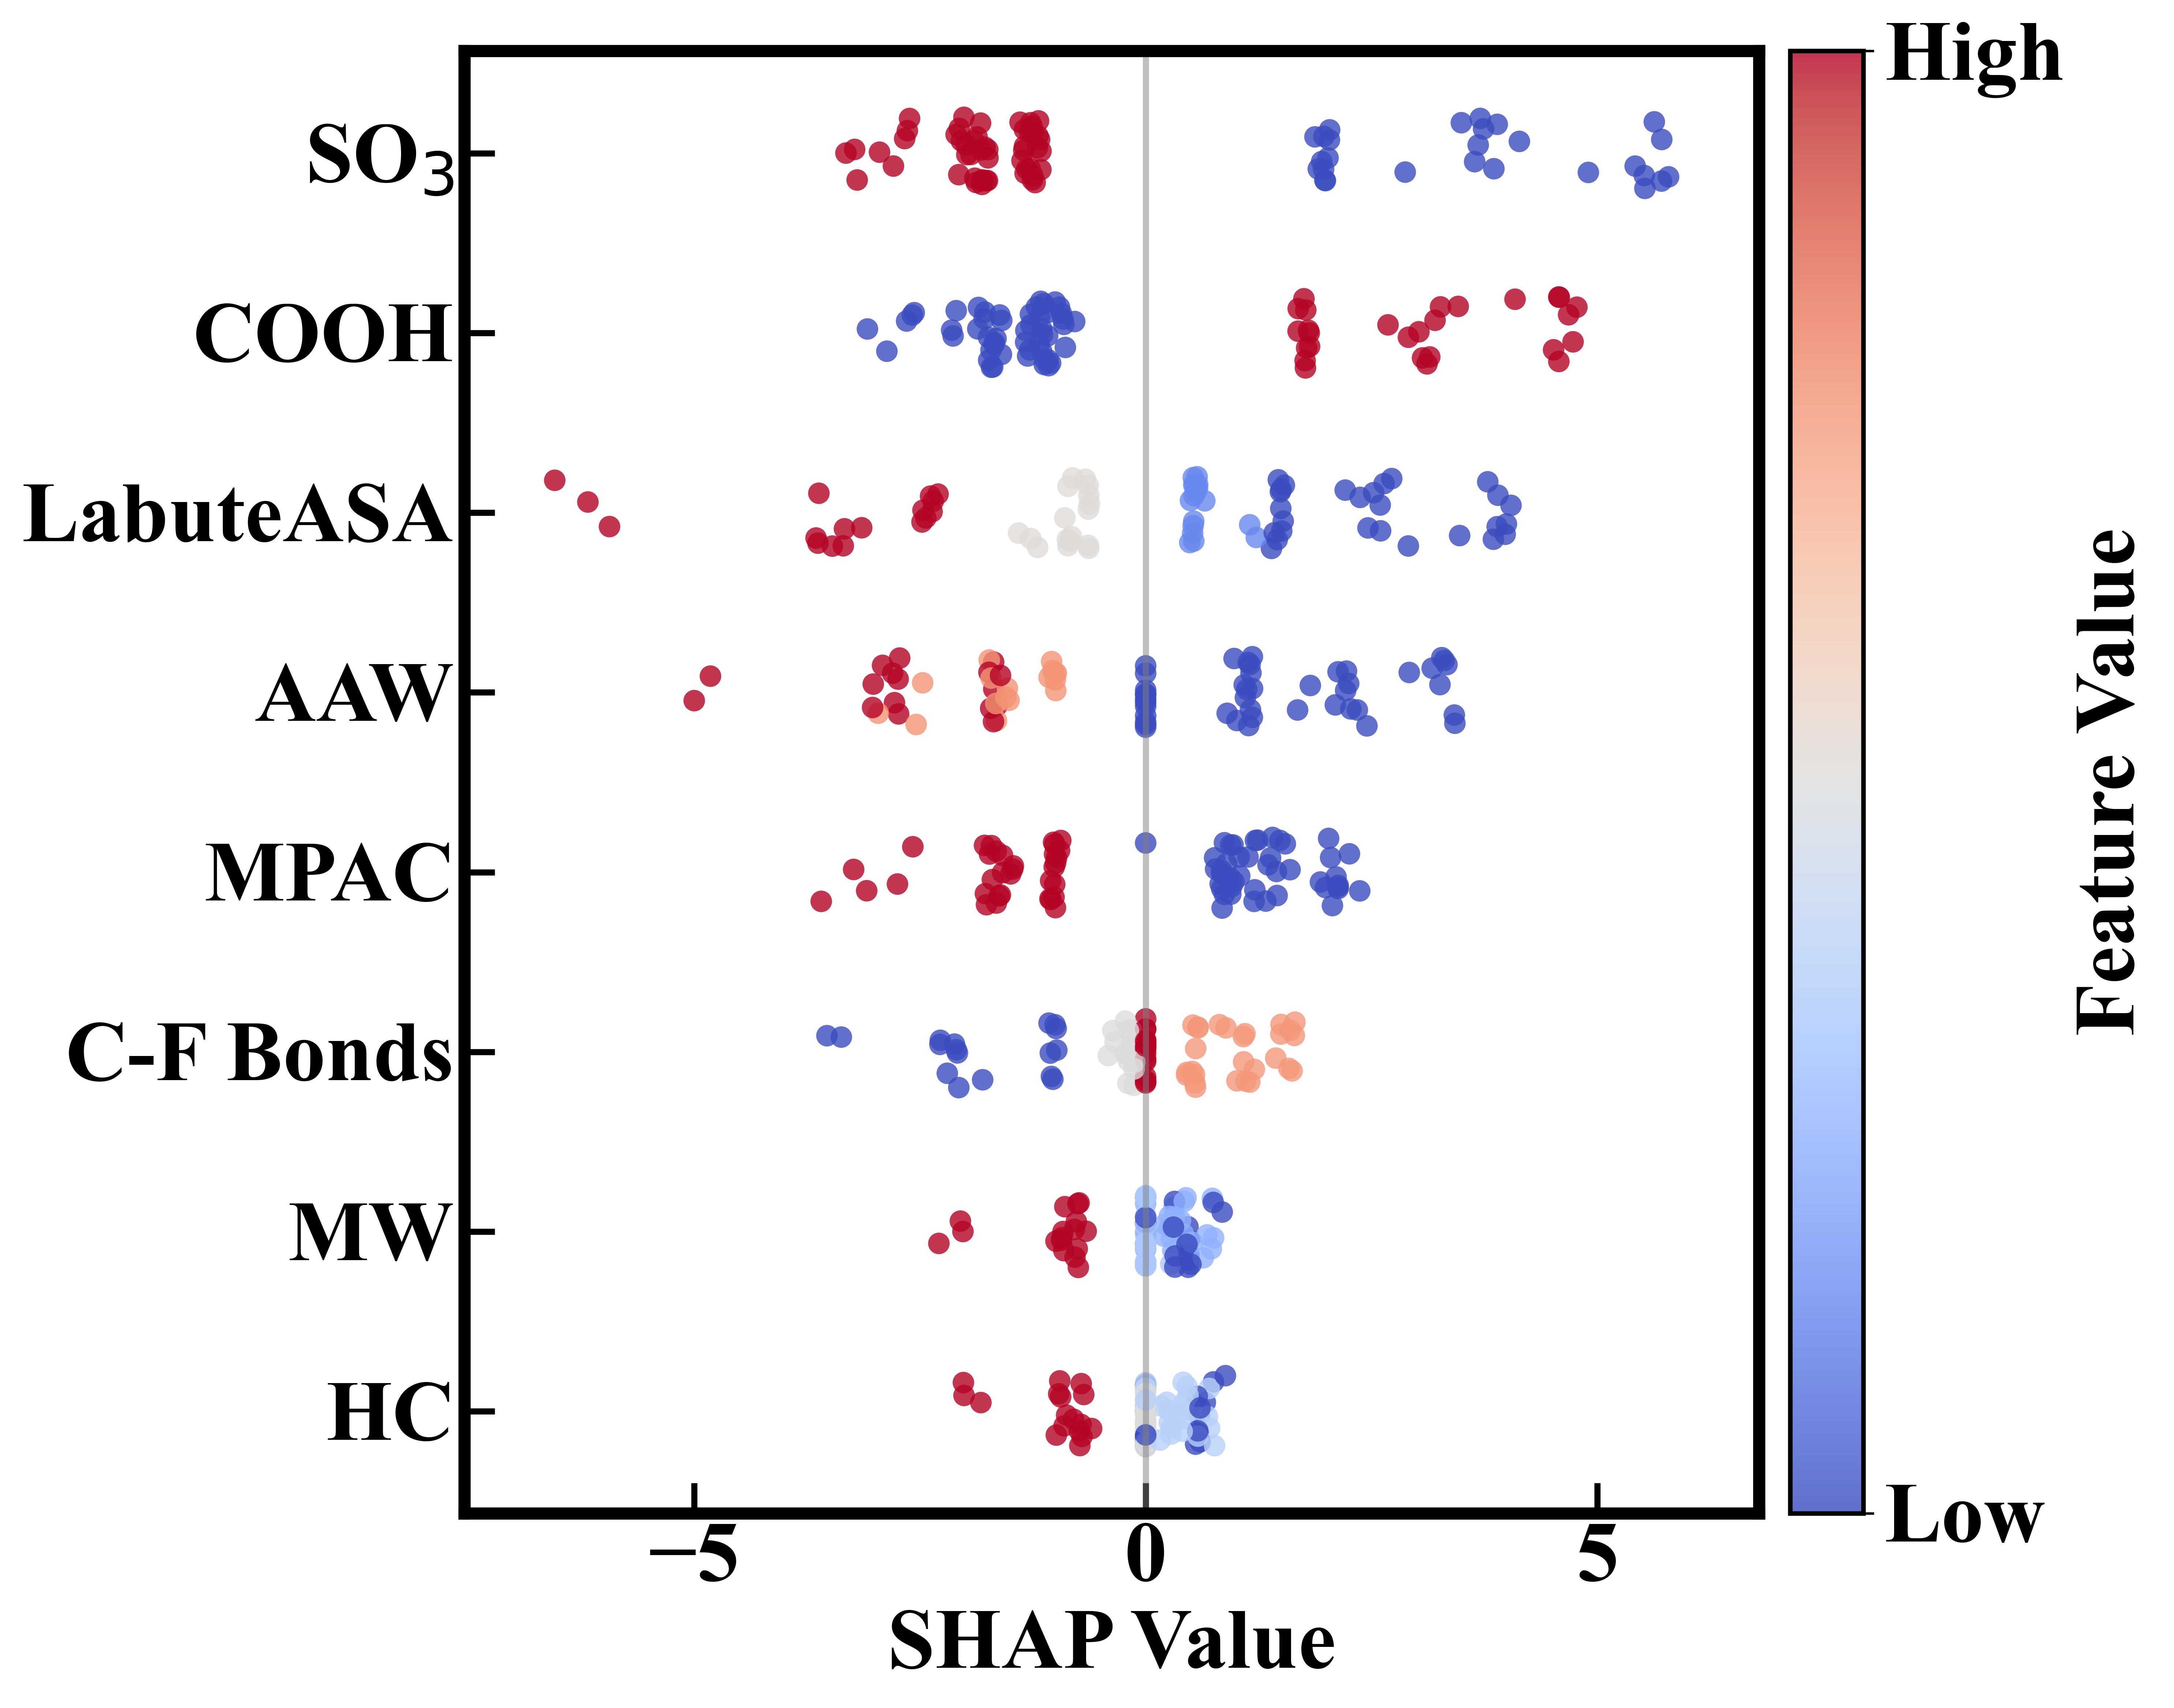

In [9]:
_ = analyze_all_features_shap() 